In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parameters

In [2]:
file_path = '/home/berger/Data/Synchrony/Paper/Fig_A01'

In [3]:
K_D_f = 1
K_D_o = 0.5

hill_f = 2
hill_o = 10

pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

# Functions

In [4]:
def prob_open_combined(v_per_ori, K_D_fx, K_D_ox, hill_fx, hill_ox):
    return 1/(1+K_D_o**hill_ox * (1+(K_D_f / v_per_ori)**hill_fx)**hill_ox)

def f_of_v(v_per_ori, K_D_fx, hill_fx):
    return 1/(1+(K_D_fx/v_per_ori)**hill_fx)

def prob_open_of_f(fract, K_D_ox, hill_ox):
    return 1/(1+(K_D_ox/fract)**hill_ox)

def prob_open_of_v_th(v, K_D, hill_eff):
    return v**hill_eff /(K_D**hill_eff + v**hill_eff)

# Make data frame

In [5]:
def generate_dict_frac(volume, prob_open, fraction, hill_fx, hill_ox, n_eff_fit):
    return {
        "volume": volume,
        "prob_open": prob_open,
        "fraction": fraction,
        "n_eff": hill_fx * hill_ox /2,
        "n": hill_fx,
        "m": hill_ox,
        "n_eff_fit":n_eff_fit}

def fitting_hill_funct(v, alpha, k, v_tilde):
    return alpha /(1+(v_tilde/v)**k)

def generate_data_frame(list_of_volumes, list_of_hill_f, list_of_hill_o):
    dictionary_list = []
    for indx_f in list_of_hill_f:
        prob_open = prob_open_combined(volume, K_D_f, K_D_o, indx_f, indx_f)
        popt, pcov = curve_fit(fitting_hill_funct, volume, prob_open)
        for volume_indx in list_of_volumes:
            fraction = f_of_v(volume_indx, K_D_f, indx_f)
            prob_open = prob_open_combined(volume_indx, K_D_f, K_D_o, indx_f, indx_f)
            dictionary = generate_dict_frac(volume_indx, prob_open, fraction, 
                                               indx_f, indx_f, popt[1])
            dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_hill_coefs(n, n_eff_fit):
    return "n=m={}".format(int(n))+"\n"+r'$(n_{{eff}}^{{fit}}={})$'.format(np.round(n_eff_fit,1))

def make_legend_hill_coef_n(n):
    return r'n={}'.format(int(n))

list_of_hill_f = [6, 7, 8]
list_of_hill_o = [6, 7, 8]
volume = np.arange(0.01, 2, 0.01)

data_frame = pd.DataFrame(generate_data_frame(volume, list_of_hill_f, list_of_hill_o))
data_frame.loc[:, 'legend_hill_coefs'] = data_frame.apply(lambda row: make_legend_hill_coefs(row.n, row.n_eff_fit)
                                                          , axis = 1)
data_frame.loc[:, 'legend_hill_coef_n'] = data_frame.apply(lambda row: make_legend_hill_coef_n(row.n)
                                                          , axis = 1)

# Fitting data list

In [10]:
def generate_dict_fitting(volume, prob_open, fraction, hill_fx, hill_ox, popt):
    return {
        "volume": volume,
        "prob_open": prob_open,
        "fraction": fraction,
        "n_eff": hill_fx * hill_ox /2,
        "n": hill_fx,
        "m": hill_ox,
        "popt": popt, 
    }

def generate_fitting_data_frame(volume, list_of_hill_f, list_of_hill_o):
    dictionary_list = []
    for indx_f in list_of_hill_f:
#         for indx_o in list_of_hill_o:
        fraction = f_of_v(volume, K_D_f, indx_f)
        prob_open = prob_open_combined(volume, K_D_f, K_D_o, indx_f, indx_f)
        popt, pcov = curve_fit(fitting_hill_funct, volume, prob_open)
#             print(popt[1])
        dictionary = generate_dict_fitting(volume, prob_open, fraction, 
                                           indx_f, indx_f, popt)
        dictionary_list.append(dictionary)
    return dictionary_list

fitting_param_list = generate_fitting_data_frame(volume, list_of_hill_f, list_of_hill_o)
# fitting_param_list

# Plot Fig A1a opening probability as a function of the volume with fit

[ 0.97358546 18.17794606  1.0016123 ]
[ 0.98531544 24.35494738  1.00203721]
[ 0.99164292 31.61978442  1.00179801]


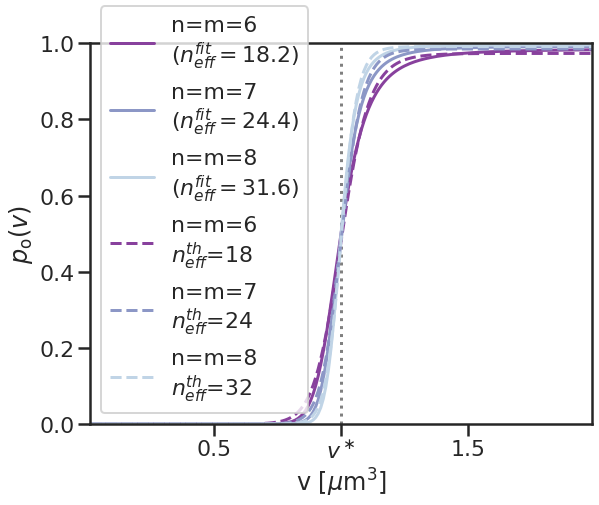

In [11]:
import matplotlib as matplotlib
sns.set(style="ticks")
sns.set_context("poster")
pallette = 'RdYlGn'
# color_list = sns.color_palette(pallette, 9)
pallette1 = 'BuPu_r'
color_list1 = sns.color_palette(pallette1, 3)
pallette2 = 'Blues'
color_list2 = sns.color_palette(pallette2, 3)
pattette3 = 'Greens'
color_list3 = sns.color_palette(pattette3, 3)
color_list = color_list1 + color_list2 + color_list3
# print(color_list)
fig, ax = plt.subplots(figsize=(9,7))
plt.axvline(x=K_D_f, color='grey', linewidth=3, linestyle='dotted')
sns.lineplot(
    x='volume', 
    y='prob_open',
    data=data_frame,
    hue='legend_hill_coefs',
#     legend = False,
    palette= color_list1
#     linestyle='dotted'
);
counter = 0
for item in fitting_param_list:
    popt =  item["popt"]
    print(popt)
    plt.plot(item["volume"], 
             fitting_hill_funct(volume, *item["popt"]), 
#              prob_open_of_v_th(item["volume"], K_D_f, item["n_eff"]),
             linestyle = '--',
             label="n=m={}".format(int(item["n"]))+"\n"+r'$n_{{eff}}^{{th}}$={}'.format(int(item["n_eff"])),
             color= color_list1[counter])
    counter = counter + 1

ax.set(ylim=(0,1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_xticks([0.5, 1, 1.5])
ax.set_xticklabels([r'0.5', r'$v^\ast$', r'1.5'])
ax.margins(0)
ax.set(xlabel=r'v [$\mu$m$^3$]', ylabel=r'$p_{\rm o}(v)$')
plt.savefig(file_path + '/prob_open.pdf', format='pdf', bbox_inches='tight')

# Figure A1b for appendix of paper

In [12]:
def generate_dict_frac_paper(n_eff_fit, hill_fx, hill_ox):
    return {
        "n_eff_fit": n_eff_fit,
        "n_eff_th": hill_fx * hill_ox /2,
        "n": hill_fx,
        "m": hill_ox}

def generate_data_frame_paper(list_of_volumes, list_of_hill_n, list_of_hill_m):
    dictionary_list = []
    for indx1 in list_of_hill_n:
        for indx2 in list_of_hill_m:
            prob_open = prob_open_combined(volume, K_D_f, K_D_o, indx1, indx2)
            popt, pcov = curve_fit(fitting_hill_funct, volume, prob_open)
            dictionary = generate_dict_frac_paper(popt[1], 
                                               indx1, indx2)
            dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_hill_coefs_paper(m):
    return r'm={}'.format(int(m))

list_of_hill_paper_n = list(np.arange(2, 11, 1))
list_of_hill_paper_m = list(np.arange(2, 11, 2))
print(len(list_of_hill_paper_m))
data_frame_paper = pd.DataFrame(generate_data_frame_paper(volume, list_of_hill_paper_n, list_of_hill_paper_m))
data_frame_paper.loc[:, 'Hill coefficient:'] = data_frame_paper.apply(lambda row: make_legend_hill_coefs_paper(row.m)
                                                          , axis = 1)

5


/home/berger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


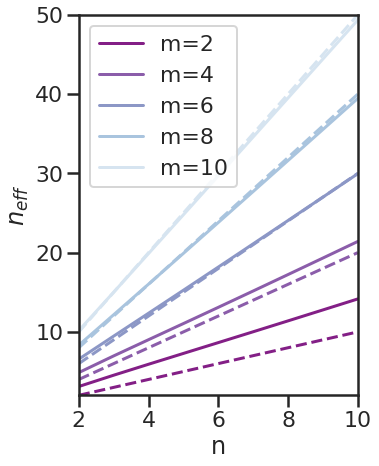

In [13]:
import matplotlib as matplotlib
sns.set(style="ticks")
sns.set_context("poster")
pallette = 'RdYlGn'
# color_list = sns.color_palette(pallette, 9)
pallette1 = 'BuPu_r'
color_list1 = sns.color_palette(pallette1, 5)
# pallette2 = 'Blues'
# color_list2 = sns.color_palette(pallette2, 3)
# pattette3 = 'Greens'
# color_list3 = sns.color_palette(pattette3, 3)
color_list = color_list1 + color_list2 + color_list3
# print(color_list)
fig, ax = plt.subplots(figsize=(5,7))
sns.lineplot(
    x='n', 
    y='n_eff_th',
    linestyle="dashed",
    data=data_frame_paper,
    hue='Hill coefficient:',
    legend = False,
    palette= color_list1
); 
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.lines[4].set_linestyle("--")
sns.lineplot(
    x='n', 
    y='n_eff_fit',
    data=data_frame_paper,
    hue='Hill coefficient:',
#     legend = True,
    palette= color_list1
);
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# handles, labels = ax.get_legend_handles_labels()
# ax.set(ylim=(0,1))
ax.margins(0)
# ax.legend(handles=handles[1:], labels=labels[1:])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel=r'n', ylabel=r'$n_{eff}$')
plt.savefig(file_path + '/vary_hill_coeff.pdf', format='pdf', bbox_inches='tight')

# Theoretical derivation of scaling

In [14]:
def binomial_coefficient(m, k):
    return np.math.factorial(m)/(np.math.factorial(k) * np.math.factorial(m-k))
    

In [15]:
m = 10
k_range = np.arange(-m/2, m/2+1)
print(k_range)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [16]:
binomial_coeff = np.array([binomial_coefficient(m, x+ m/2) for x in k_range])
print(binomial_coeff)

[  1.  10.  45. 120. 210. 252. 210. 120.  45.  10.   1.]


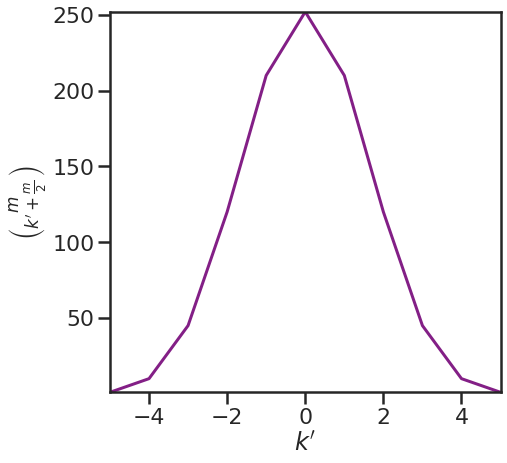

In [17]:
dark_blue = (0.5146020761245674, 0.12110726643598616, 0.5273817762399078)

sns.set(style="ticks")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(k_range, binomial_coeff, color=dark_blue)
ax.set(xlabel=r'$k^\prime$', ylabel=r'$\binom{m}{k^\prime + \frac{m}{2}}$')
ax.margins(0)
plt.savefig(file_path + '/binomial_coeff.pdf', format='pdf', bbox_inches='tight')

In [18]:
n = 10
m = 10

def volume_term(volume_, n_, m_, k_):
    return volume_**(n_ * (m_/2 - k_))

def volume_term_approx(volume_, n_, m_):
    return volume_**(n_ * (m_/2))


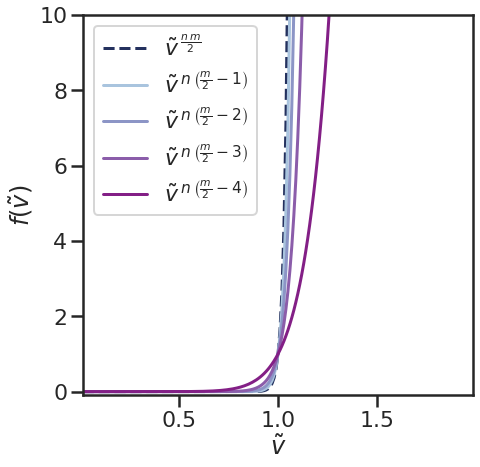

In [19]:
dark_blue = (36 / 255, 49 / 255, 94 / 255)

sns.set(style="ticks")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(7,7))

range_of_ks = 5
color_list_term2 = sns.color_palette('BuPu', range_of_ks)
ax.plot(volume/K_D_f, volume_term_approx(volume/K_D_f, n, m), label=r'$\tilde{v}\,^{\frac{n \, m}{2}}$', color=dark_blue, linestyle='dashed')
for item in range(1, range_of_ks):
    ax.plot(volume/K_D_f, volume_term(volume/K_D_f, n, m, item), color=color_list_term2[item], label=r'$\tilde{{v}}\,^{{n \, \left(\frac{{m}}{{2}}- {}\right)}}$'.format(item))
ax.set(ylim=(-0.1, 10))
# ax.set(xlim=(0, 1.1))
ax.set(xlabel=r'$\tilde{v}$', ylabel=r'$f(\tilde{v})$')
ax.margins(0)
ax.legend()
plt.savefig(file_path + '/term2.pdf', format='pdf', bbox_inches='tight')